In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas
import numpy as np
import time 

from sklearn.model_selection import train_test_split
from itertools import zip_longest
from Bio.Seq import translate, IUPAC
from torch.nn import functional as F
from scipy.stats import skewnorm
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Reshape, Softmax
from tensorflow.keras import Model
from keras.datasets import mnist


def normalize(X):
    """
    :param X: dataframe or numpy array to be normalized
    :return: dataframe or numpy array that is normalized
    >>> normalize(np.array([0, 1, 2]))
    array([-1.22474487,  0.        ,  1.22474487])
    """
    return (X - X.mean()) / X.std()



def get_gfp_data(amino_acid=False, gfp_data_path="../data/gfp_data.csv", x_feature="nucSequence", y_feature="medianBrightness", normalize_y=True, test_size=0.2, shuffle=False):
    """
    :param amino_acid:  amino acid format or DNA
    :param gfp_data_path: gfp data path
    :param x_feature: column to use for x data
    :param y_feature: column to use for y data
    :param normalize_y: normalize y or not
    :param test_size: size of test set
    :param shuffle: shuffle data or not
    :return: gfp data split across train and test set
    """
    df = pd.read_csv(gfp_data_path, index_col=0)
    if amino_acid: 
        x = df[x_feature].apply(lambda x: dna_to_amino_acid(x)).values
    else: 
        x = df[x_feature].values
    y = df[y_feature].values
    if normalize_y: 
        y = normalize(y)
    return train_test_split(x, y, test_size=test_size, shuffle=shuffle)



def one_hot_encode(X, alphabet):
    """
    one hot encode a list of strings
    :param X: list of sequences represented by the set of letters in alphabet
    :param alphabet:
    :return: one hot encoded list of X sequences
    """
    """
    Input: X is a list of sequences represented by the set of letters in alphabet
        All sequences must be the same length
    Output: one hot encoded list of X sequences
    Example: one_hot_encode(["ACT", "ACG"], "ACTG") = [[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]
    """
    assert(len(X) > 0)
    assert(all([len(X[0]) == len(X[i]) for i in range(len(X))]))
    alphabet_size = len(alphabet)
    alphabet_dict = dict(zip(alphabet, range(alphabet_size)))
    one_hot_matrix = np.zeros((len(X), alphabet_size * len(X[0])))
    for i, sequence in enumerate(X):
        for j, letter in enumerate(sequence):
            if letter not in alphabet:
                raise KeyError("letter not in alphabet")
            index = alphabet_dict[letter]
            one_hot_matrix[i, alphabet_size * j + index] = 1.0
    return one_hot_matrix


def one_hot_decode(X, alphabet):
    """
    one hot decode a matrix
    :param X: one hot encoded list of DNA Sequences represented by the alphabet
    :param alphabet: all the letters in the vocabulary of X
    :return: a one hot decoded matrix in list of strings format
    >>> one_hot_decode([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], \
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]], "ACTG")
    ['ACT', 'ACG']
    """
    assert(len(X) > 0)
    assert(all([len(X[0]) == len(X[i]) for i in range(len(X))]))
    alphabet_size = len(alphabet)
    sequences_lst = []
    for i, one_hot_sequence in enumerate(X):
        sequence, sequence_len = [], len(one_hot_sequence)
        for j in range(0, sequence_len, alphabet_size):
            index = np.argmax(one_hot_sequence[j:j+alphabet_size])
            sequence.append(alphabet[index])
        sequences_lst.append("".join(sequence))
    return sequences_lst


import pandas as pd
import numpy as np
import time 
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from itertools import zip_longest
from Bio.Seq import translate, IUPAC
from torch.nn import functional as F
from scipy.stats import skewnorm


def normalize(X):
    """
    :param X: dataframe or numpy array to be normalized
    :return: dataframe or numpy array that is normalized
    >>> normalize(np.array([0, 1, 2]))
    array([-1.22474487,  0.        ,  1.22474487])
    """
    return (X - X.mean()) / X.std()


def get_wild_type_dna_sequence():
    """
    :return: string of wild type dna sequence from cached location
    """
    return "AGCAAGGGCGAGGAGCTGTTCAC" \
           "CGGGGTGGTGCCCATCCTGGTCG" \
           "AGCTGGACGGCGACGTAAACGGC" \
           "CACAAGTTCAGCGTGTCCGGCGA" \
           "GGGCGAGGGCGATGCCACCTACG" \
           "GCAAGCTGACCCTGAAGTTCATC" \
           "TGCACCACCGGCAAGCTGCCCGT" \
           "GCCCTGGCCCACCCTCGTGACCA" \
           "CCCTGTCATACGGCGTGCAGTGC" \
           "TTCAGCCGCTACCCCGACCACAT" \
           "GAAGCAGCACGACTTCTTCAAGT" \
           "CCGCCATGCCCGAAGGCTACGTC" \
           "CAGGAGCGCACCATCTTCTTCAA" \
           "GGACGACGGCAACTACAAGACCC" \
           "GCGCCGAGGTGAAGTTCGAGGGC" \
           "GACACACTAGTGAACCGCATCGA" \
           "GCTGAAGGGCATCGACTTCAAGG" \
           "AGGACGGCAACATCCTGGGGCAC" \
           "AAGCTGGAGTACAACTACAACAG" \
           "CCACAACGTCTATATCATGGCCG" \
           "ACAAGCAGAAGAACGGCATCAAG" \
           "GTGAACTTCAAGATCCGCCACAA" \
           "CATCGAGGACGGCAGCGTGCAGC" \
           "TCGCCGACCACTACCAGCAGAACA" \
           "CCCCCATCGGCGACGGCCCCGTGC" \
           "TGCTGCCCGACAACCACTACCTGA" \
           "GCACCCAGTCCGCCCTGAGCAAAGA" \
           "CCCCAACGAGAAGCGCGATCACAT" \
           "GGTCCTGCTGGAGTTCGTGACCGC" \
           "CGCCGGGATCACTCACGGCATGGA" \
           "CGAGCTGTACAAGTGA"

def count_substring_mismatch(s1, s2):
    """
    :param s1: string one
    :param s2: string two
    :return: int of the number of mismatches between the two sequences
    >>> count_substring_mismatch('1', '2')
    1
    >>> count_substring_mismatch('ACT', 'ACGA')
    2
    """
    return sum([i != j for i, j in zip_longest(s1, s2)])

def filter_data_less_than_zero(x_train, x_test, y_train,y_test): 
    x_train_filter = []
    y_train_filter = []
    x_test_filter = []
    y_test_filter = []
    for x, y in zip(x_train, y_train):
        if y > 0: 
            x_train_filter.append(x)
            y_train_filter.append(y)
    for x, y in zip(x_test, y_test):
        if y > 0: 
            x_test_filter.append(x)
            y_test_filter.append(y)
    return x_train_filter, x_test_filter, y_train_filter, y_test_filter

In [69]:
x_train, x_test, y_train, y_test = get_gfp_data()
NUM_DATA = 5000
x_train, x_test, y_train, y_test = x_train[:NUM_DATA], x_test[:NUM_DATA], y_train[:NUM_DATA], y_test[:NUM_DATA]
x_train, x_test, y_train, y_test = filter_data_less_than_zero(x_train, x_test, y_train, y_test)
train_x = one_hot_encode(x_train, "ACTG")
test_x = one_hot_encode(x_test, "ACTG")    

In [5]:
assert(all([y >= 0 for y in y_train]))
assert(all([y >= 0 for y in y_test]))
assert(len(y_train) == len(x_train))
assert(len(x_test) == len(y_test))

In [70]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, y_test)).batch(BATCH_SIZE)

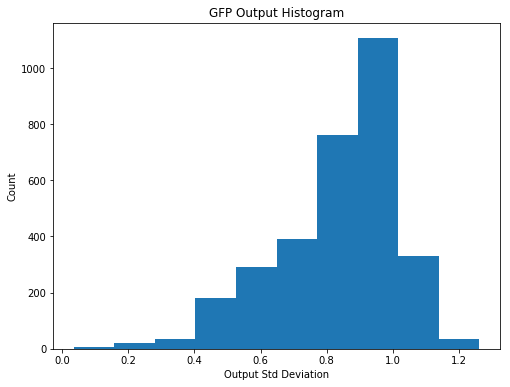

In [169]:
plt.figure(figsize = (8, 6))
plt.hist(y_train)
plt.xlabel("Output Std Deviation")
plt.ylabel("Count")
plt.title("GFP Output Histogram")
plt.savefig("../plots/gfp_output_histogram.png")
plt.show()
plt.close()

In [79]:
class MyModel(Model):
    #To Do: add way to make inputs drawn from probability simplex
    def __init__(self):
        super(MyModel, self).__init__()
        self.reshape = Reshape((-1, 714, 4), name = 'reshape')
        self.softmax = Softmax(axis=-1, name = 's1')
        self.flatten = Flatten()
        self.d1 = Dense(500, name='d1')
        self.r1 = Activation('relu', name = 'r1')
        self.d2 = Dense(100, name='d2')
        self.r2 = Activation('relu', name = 'r1')
        self.d3 = Dense(1, name='d3')

    def call(self, x):
        x = self.reshape(x)
        x = self.softmax(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        x = self.r2(x)
        return self.d3(x)
        
    
model = MyModel()

In [83]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [84]:
# define own function
def train_step(model, inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_object(outputs, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    
def test_step(model, inputs, outputs):
    predictions = model(inputs)
    t_loss = loss_object(outputs, predictions)
    test_loss(t_loss)
    
def train(model, train_ds, test_ds, EPOCHS=1): 
    for epoch in range(EPOCHS):
        for inputs, outputs in train_ds:
            train_step(model, inputs, outputs)

        for inputs, outputs in test_ds:
            test_step(model, inputs, outputs)
        
        template = 'Epoch {}, Loss: {}, Test Loss: {}'
        print(template.format(epoch+1,
                            train_loss.result().numpy(),
                            test_loss.result().numpy()))
        # Reset the metrics for the next epoch
        train_loss.reset_states()
        test_loss.reset_states()
            


In [85]:
train(model, train_dataset, test_dataset, 30)

Epoch 1, Loss: 0.03466008976101875, Test Loss: 0.04301457852125168
Epoch 2, Loss: 0.04376210272312164, Test Loss: 0.04084521904587746
Epoch 3, Loss: 0.04090998321771622, Test Loss: 0.03987811133265495
Epoch 4, Loss: 0.04038068652153015, Test Loss: 0.03933415189385414
Epoch 5, Loss: 0.039725400507450104, Test Loss: 0.041076384484767914
Epoch 6, Loss: 0.03992495313286781, Test Loss: 0.04083016514778137
Epoch 7, Loss: 0.04076150804758072, Test Loss: 0.03884883224964142
Epoch 8, Loss: 0.039759308099746704, Test Loss: 0.03905710205435753
Epoch 9, Loss: 0.03946857526898384, Test Loss: 0.038952648639678955
Epoch 10, Loss: 0.039005346596241, Test Loss: 0.03872991353273392
Epoch 11, Loss: 0.03938502445816994, Test Loss: 0.03883296251296997
Epoch 12, Loss: 0.039428167045116425, Test Loss: 0.03889887034893036
Epoch 13, Loss: 0.039566442370414734, Test Loss: 0.038687098771333694
Epoch 14, Loss: 0.03945483639836311, Test Loss: 0.03893511742353439
Epoch 15, Loss: 0.039397016167640686, Test Loss: 0.0

In [108]:
def convert_simplex_to_sequence(tensor, return_probs=False, return_argmax=False, return_dna=False): 
    assert return_probs + return_argmax + return_dna == 1
    dna_mp = {
        0 : "A", 
        1 : "C", 
        2 : "T", 
        3 : "G"
    }
    probs = tf.reshape(tensor, (-1, 4)).numpy()
    if return_probs: 
        return probs
    argmax_lst = np.argmax(probs, axis = -1)
    if return_argmax: 
        return argmax_lst
    dna = "".join([dna_mp[i] for i in argmax_lst])
    if return_dna:
        return dna

In [125]:
one_hot_wild_type_sequence = one_hot_encode([get_wild_type_dna_sequence()], "ACTG")
tf.convert_to_tensor(one_hot_wild_type_sequence)

<tf.Tensor: id=479572, shape=(1, 2856), dtype=float64, numpy=array([[1., 0., 0., ..., 0., 0., 0.]])>

In [156]:
def plot_gradient_ascent(title, loss_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst): 
    plt.figure(figsize=(8, 6))
    plt.title("{} Gradient Ascent Output".format(title), fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Gfp Output", fontsize=12)
    plt.plot(loss_lst, 'ro--')
    plt.show()
    plt.close()
    plt.figure(figsize = (8, 6))
    plt.title("{} Hamming Difference".format(title), fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Hamming Distance from Wild Type", fontsize=12)
    plt.plot(hamming_lst, 'bo--')
    plt.show()
    plt.close()
    plt.title("{} Prob entropy".format(title), fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Average entropy", fontsize=12)
    prob_entropy_lst = []
    for probs in prob_lst: 
        prob_mean = np.mean([scipy.stats.entropy(x) for x in probs])
        prob_entropy_lst.append(prob_mean)
    plt.plot(prob_entropy_lst, 'go--')
    plt.show()
    plt.close()

In [160]:
print(max(y_train))

1.261926722883848


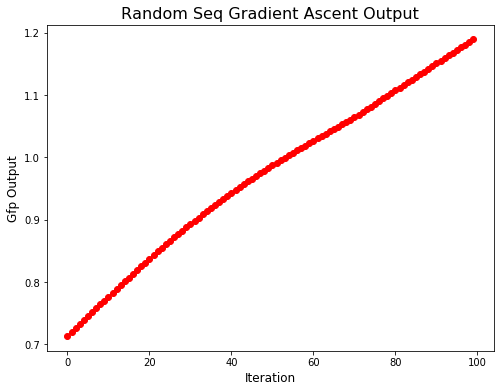

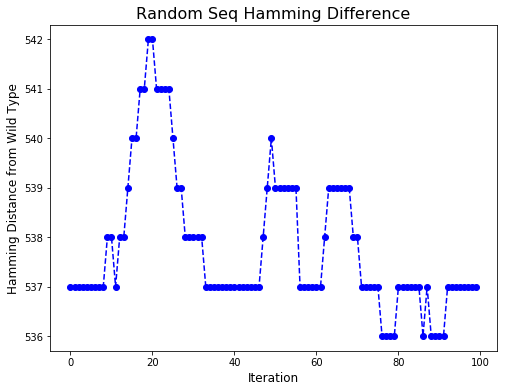

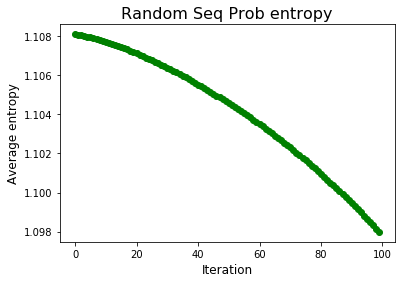

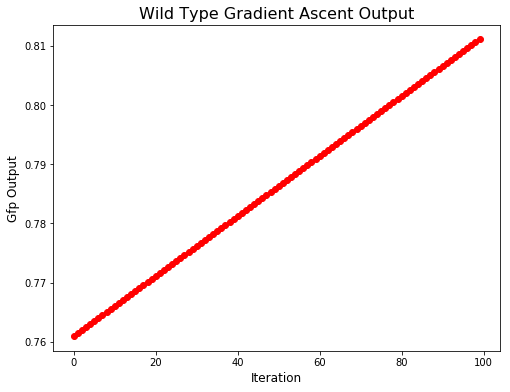

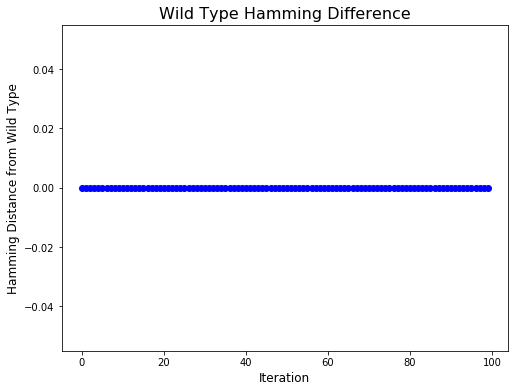

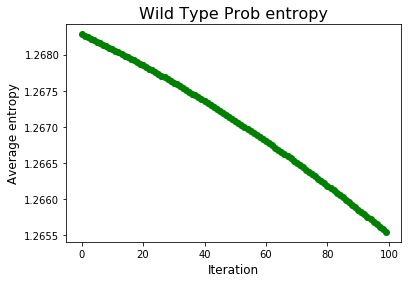

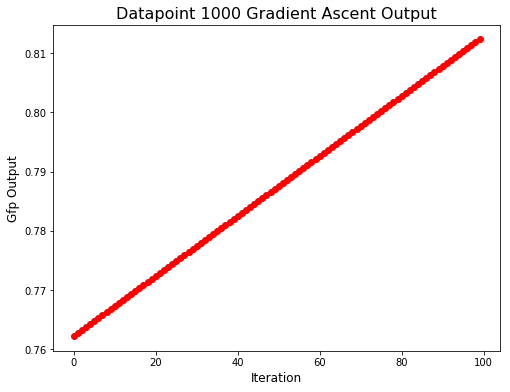

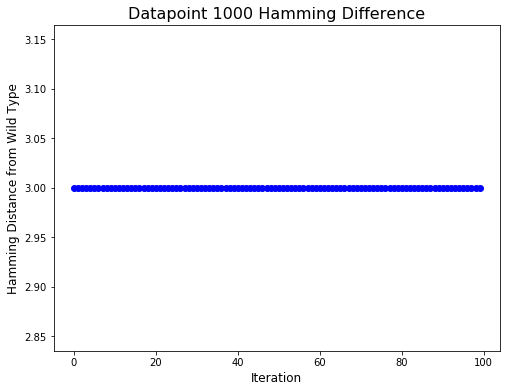

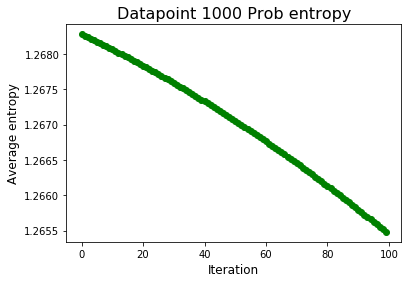

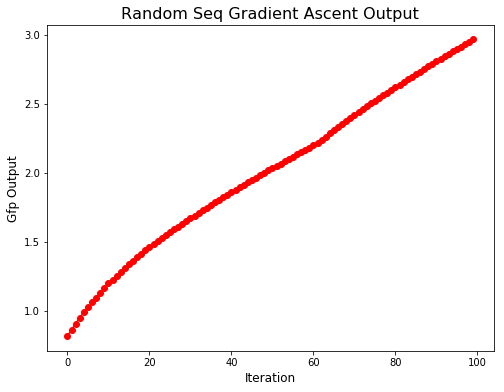

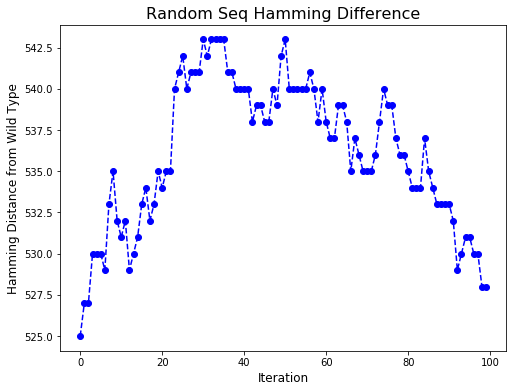

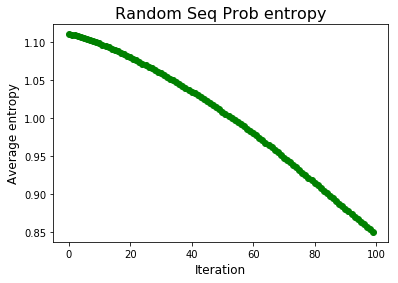

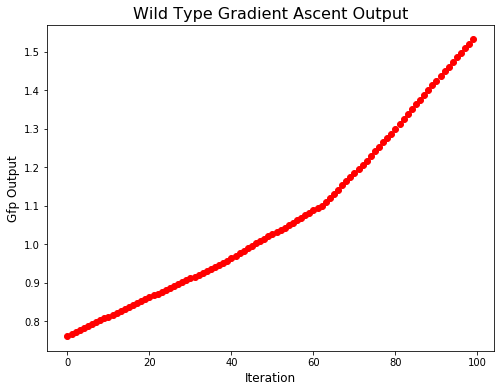

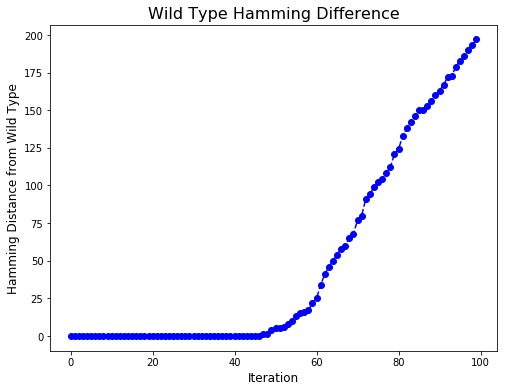

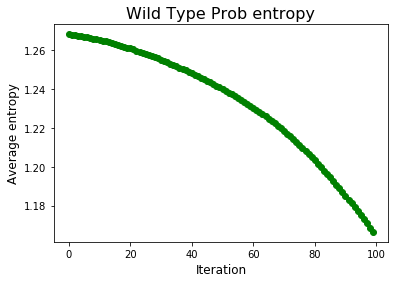

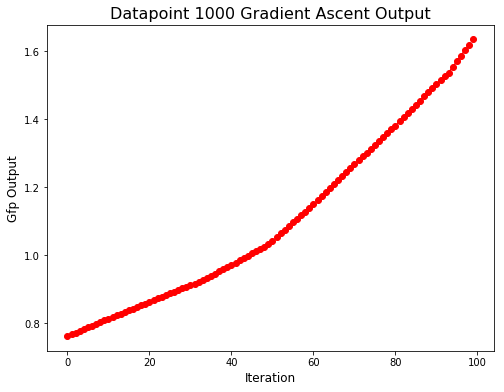

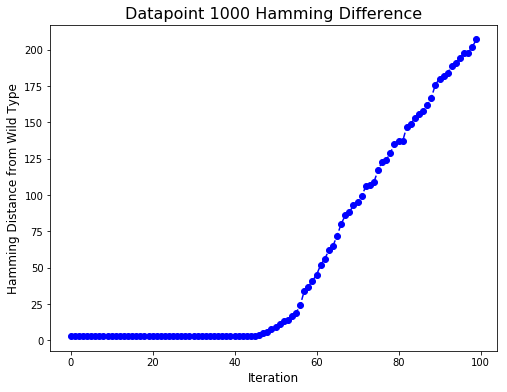

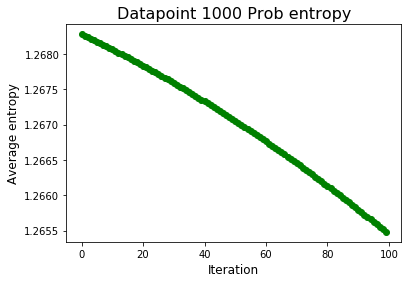

In [174]:
def gradient_ascent(model, input_tensor, iterations = 100, lr=10.0, clip=False):
    softmax_model = tf.keras.Sequential([model.layers[0], model.layers[1], model.layers[2]])
    length = len(input_tensor) * 4
    am_input = tf.Variable(tf.cast(tf.convert_to_tensor([input_tensor]), tf.float32), trainable=True)
    learning_rate = tf.constant(lr)
    loss_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst = [], [], [], [], []
    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = model(am_input)
        am_gradient = tape.gradient(loss, am_input) 
        am_input.assign_add(learning_rate * am_gradient)
        if clip: 
            am_input = tf.Variable(tf.clip_by_value(am_input, 0, 1), trainable=True) 
        prob_tensor = softmax_model(am_input)
        probs = convert_simplex_to_sequence(prob_tensor, return_probs=True)
        argmax = convert_simplex_to_sequence(prob_tensor, return_argmax=True)
        sequence = convert_simplex_to_sequence(prob_tensor, return_dna=True)
        hamming_distance = count_substring_mismatch(sequence, get_wild_type_dna_sequence())
        loss_lst.append(loss.numpy()[0][0]); 
        prob_lst.append(probs)
        argmax_lst.append(argmax)
        sequence_lst.append(sequence)
        hamming_lst.append(hamming_distance)
    return loss_lst, prob_lst, argmax_lst, sequence_lst, hamming_lst

random_lr_1_loss_lst, random_lr_1_prob_lst, random_lr_1_argmax_lst, random_lr_1_sequence_lst, random_lr_1_hamming_lst = gradient_ascent(model, tf.random.normal((1, length)), lr = 1.0)
plot_gradient_ascent("Random Seq", random_lr_1_loss_lst, random_lr_1_prob_lst, random_lr_1_argmax_lst, random_lr_1_sequence_lst, random_lr_1_hamming_lst)
wild_type_lr_1_loss_lst, wild_type_lr_1_prob_lst, wild_type_lr_1_argmax_lst, wild_type_lr_1_sequence_lst, wild_type_lr_1_hamming_lst = gradient_ascent(model, tf.convert_to_tensor(train_x[0]), lr = 1.0)
plot_gradient_ascent("Wild Type", wild_type_lr_1_loss_lst, wild_type_lr_1_prob_lst, wild_type_lr_1_argmax_lst, wild_type_lr_1_sequence_lst, wild_type_lr_1_hamming_lst)
data_1000_lr_1_loss_lst, data_1000_lr_1_prob_lst, data_1000_lr_1_argmax_lst, data_1000_lr_1_sequence_lst, data_1000_lr_1_hamming_lst = gradient_ascent(model, tf.convert_to_tensor(train_x[1000]), lr = 1.0)
plot_gradient_ascent("Datapoint 1000", data_1000_lr_1_loss_lst, data_1000_lr_1_prob_lst, data_1000_lr_1_argmax_lst, data_1000_lr_1_sequence_lst, data_1000_lr_1_hamming_lst)
random_lr_10_loss_lst, random_lr_10_prob_lst, random_lr_10_argmax_lst, random_lr_10_sequence_lst, random_lr_10_hamming_lst = gradient_ascent(model, tf.random.normal((1, length)), lr = 10.0)
plot_gradient_ascent("Random Seq", random_lr_10_loss_lst, random_lr_10_prob_lst, random_lr_10_argmax_lst, random_lr_10_sequence_lst, random_lr_10_hamming_lst)
wild_type_lr_10_loss_lst, wild_type_lr_10_prob_lst, wild_type_lr_10_argmax_lst, wild_type_lr_10_sequence_lst, wild_type_lr_10_hamming_lst = gradient_ascent(model, tf.convert_to_tensor(train_x[0]), lr = 10.0)
plot_gradient_ascent("Wild Type", wild_type_lr_10_loss_lst, wild_type_lr_10_prob_lst, wild_type_lr_10_argmax_lst, wild_type_lr_10_sequence_lst, wild_type_lr_10_hamming_lst)
data_1000_lr_10_loss_lst, data_1000_lr_10_prob_lst, data_1000_lr_10_argmax_lst, data_1000_lr_10_sequence_lst, data_1000_lr_10_hamming_lst = gradient_ascent(model, tf.convert_to_tensor(train_x[1000]), lr = 10.0)
plot_gradient_ascent("Datapoint 1000", data_1000_lr_10_loss_lst, data_1000_lr_1_prob_lst, data_1000_lr_10_argmax_lst, data_1000_lr_10_sequence_lst, data_1000_lr_10_hamming_lst)





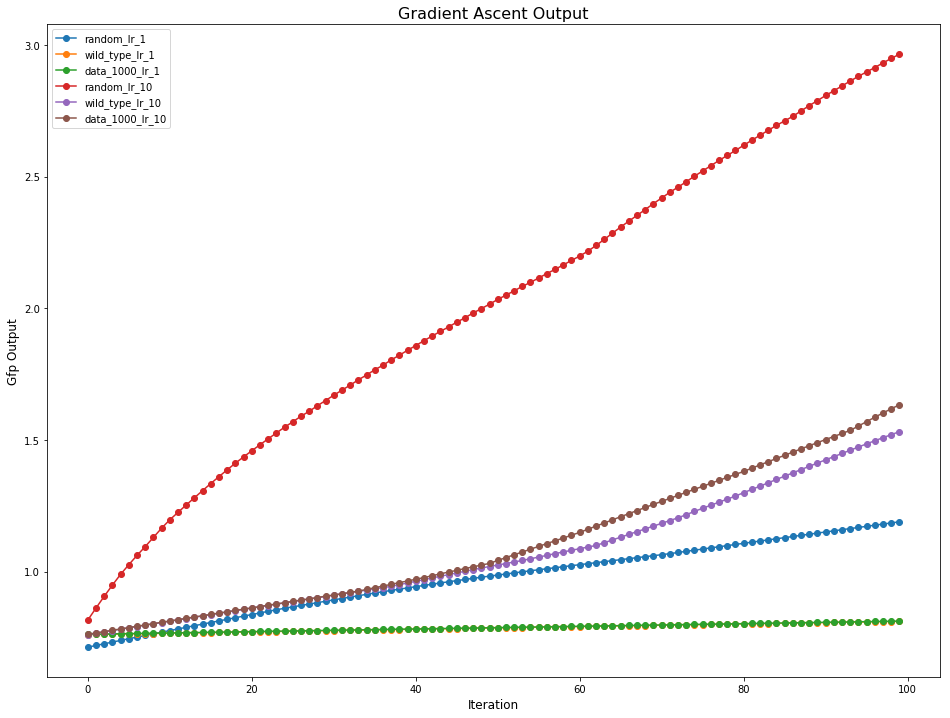

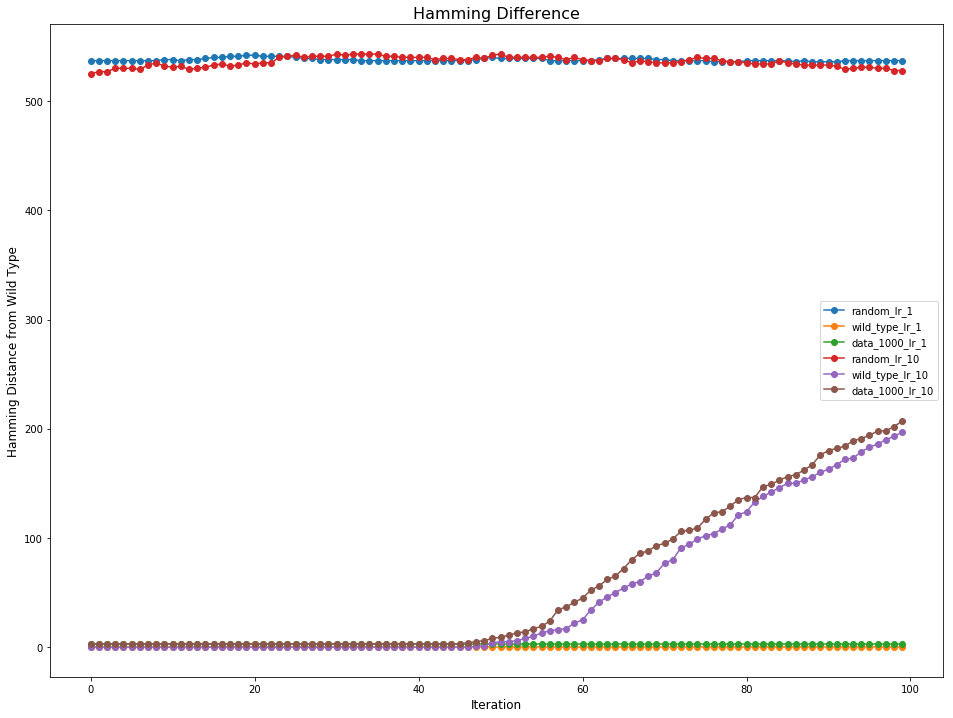

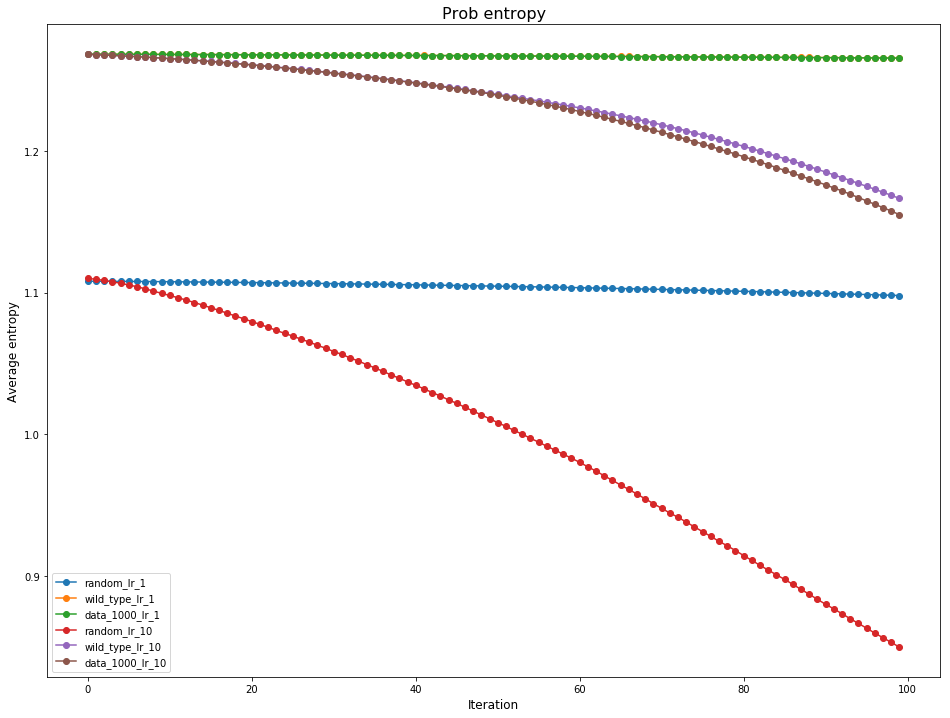

In [180]:
entropy_lst = [random_lr_1_prob_lst, wild_type_lr_1_prob_lst, data_1000_lr_1_prob_lst, random_lr_10_prob_lst, wild_type_lr_10_prob_lst, data_1000_lr_10_prob_lst,]
hamming_lst = [random_lr_1_hamming_lst, wild_type_lr_1_hamming_lst, data_1000_lr_1_hamming_lst, random_lr_10_hamming_lst, wild_type_lr_10_hamming_lst, data_1000_lr_10_hamming_lst]
gradient_output_lst = [random_lr_1_loss_lst, wild_type_lr_1_loss_lst, data_1000_lr_1_loss_lst, random_lr_10_loss_lst, wild_type_lr_10_loss_lst, data_1000_lr_10_loss_lst]
labels = ['random_lr_1', 'wild_type_lr_1', 'data_1000_lr_1', 'random_lr_10', 'wild_type_lr_10', 'data_1000_lr_10']
plt.figure(figsize=(16, 12))
plt.title("Gradient Ascent Output", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Gfp Output", fontsize=12)
for lst, label in zip(gradient_output_lst, labels): 
    plt.plot(lst, 'o-', label = label)
plt.legend()
plt.savefig("../plots/10_13_gradient_ascent_output.png")
plt.show()
plt.close()
plt.figure(figsize=(16, 12))
plt.title("Hamming Difference", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Hamming Distance from Wild Type", fontsize=12)
for lst, label in zip(hamming_lst, labels): 
    plt.plot(lst, 'o-', label = label)
plt.legend()
plt.savefig("../plots/10_13_hamming_difference.png")
plt.show()
plt.close()
plt.figure(figsize=(16, 12))
plt.title("Prob entropy", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Average entropy", fontsize=12)
prob_entropy_lst = []
for lst, label in zip(entropy_lst, labels): 
    prob_entropy_lst = []
    for probs in lst: 
        prob_mean = np.mean([scipy.stats.entropy(x) for x in probs])
        prob_entropy_lst.append(prob_mean)
    plt.plot(prob_entropy_lst, 'o-', label = label)
plt.legend()
plt.savefig("../plots/10_13_prob_entropy.png")
plt.show()
plt.close()

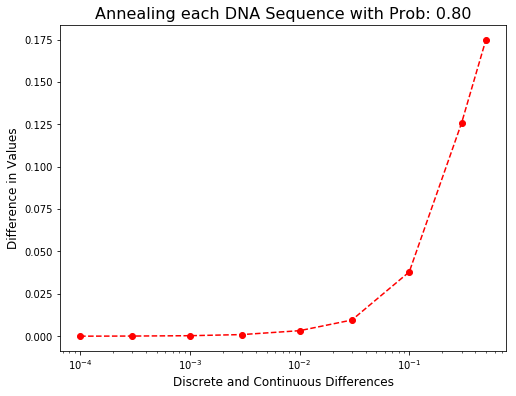

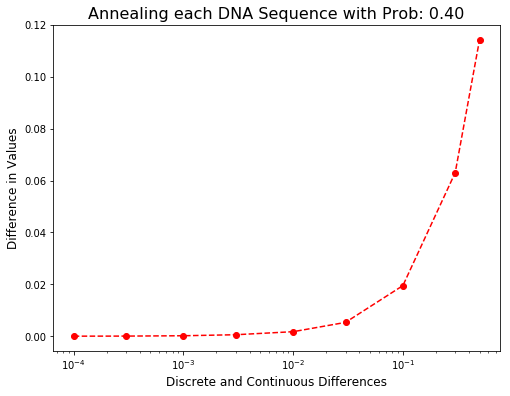

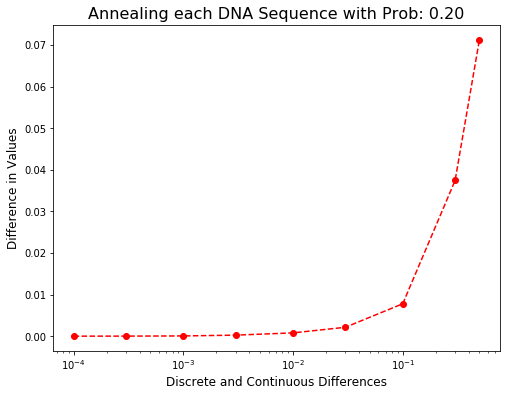

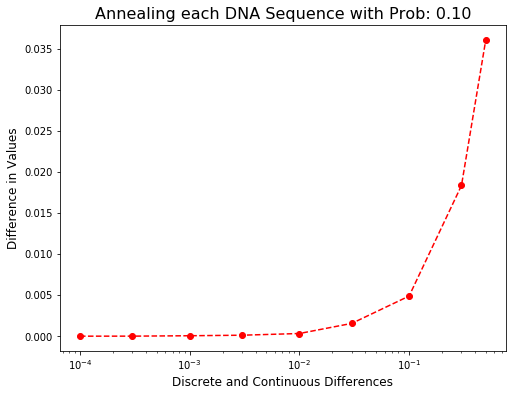

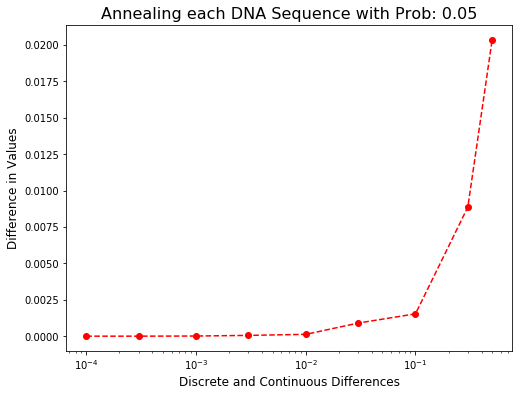

In [166]:

def select_random_index_except(i): 
    z = np.random.randint(0, 4)
    while z == i: 
        z = np.random.randint(0, 4)
    return z

def anneal_dna_sequence(model, input_dna_seq, eps, value, inv_value):
    lst = []
    mutated_dna_seq = []
    for z in input_dna_seq.reshape(-1, 4): 
        i = np.argmax(z)
        copy = z.copy()
        if np.random.random() < eps: 
            copy[i] = value
            copy[select_random_index_except(i)] = inv_value
        mutated_dna_seq.extend(copy)
    expected_value = model(tf.reshape(tf.convert_to_tensor(input_dna_seq, dtype=tf.float32), (1, -1)))
    annealed_value = model(tf.reshape(tf.convert_to_tensor(mutated_dna_seq, dtype=tf.float32), (1, -1)))
    diff = expected_value - annealed_value
    return expected_value.numpy()[0][0], annealed_value.numpy()[0][0], diff.numpy()[0]

wild_type = one_hot_encode([get_wild_type_dna_sequence()], "ACTG")
prob_search_space = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5]
eps_search_space = [0.8, 0.4, 0.2, 0.1, 0.05]
samples = 100
eps_map = {}
input_model = tf.keras.Sequential(model.layers[3:])
for eps in eps_search_space: 
    prob_diff_map = {}
    for p in prob_search_space: 
        diff_lst = []
        expected_value_lst = []
        annealed_value_lst = []
        for _ in range(samples): 
            expected_value, annealed_value, diff = anneal_dna_sequence(input_model, wild_type, eps, 1-p, p)
            annealed_value_lst.append(annealed_value)
            diff_lst.append(diff)    
        assert(all(x == expected_value_lst[0] for x in expected_value_lst))
        anneal_value = np.mean(annealed_value_lst) 
        difference = np.mean(diff_lst)
        prob_diff_map[p] = difference
    eps_map[eps] = prob_diff_map
    plt.figure(figsize = (8, 6))
    plt.title("Annealing each DNA Sequence with Prob: {0:.2f}".format(eps, p), fontsize=16)
    plt.xlabel("Discrete and Continuous Differences", fontsize=12)
    plt.xscale('log')
    plt.ylabel("Difference in Values", fontsize=12)
    plt.plot(prob_diff_map.keys(), prob_diff_map.values(), 'ro--')
    plt.show()
    plt.close()

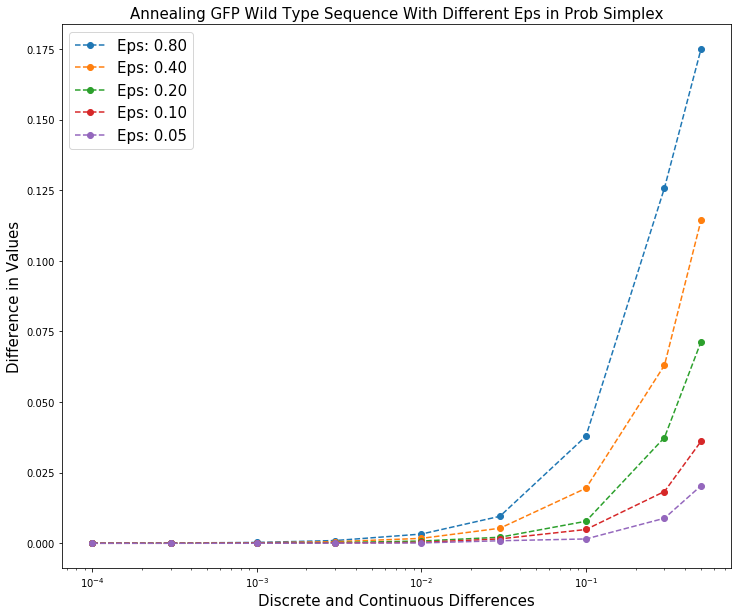

In [170]:
plt.figure(figsize = (12, 10))
plt.title("Annealing GFP Wild Type Sequence With Different Eps in Prob Simplex".format(eps, p), fontsize=15)
plt.xlabel("Discrete and Continuous Differences", fontsize=15)
plt.ylabel("Difference in Values", fontsize=15)
plt.xscale('log')
for eps, mp in eps_map.items(): 
    plt.plot(mp.keys(), mp.values(), 'o--', label="Eps: {:.2f}".format(eps))
plt.legend(fontsize=15)
plt.savefig("../plots/10_13_annealing_gfp_wild_type_seq_with_different_eps_in_prob_simplex.png") # call before show
plt.show()
plt.close()
# @Todo: eps = 1 and 1/length, reset one at a time. a real relaxation, plot in relative error a -  b / a